In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [3]:
!pip install transformers
!pip install ftfy regex tqdm

import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image


device = "cuda" if torch.cuda.is_available() else "cpu"


clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def compute_clip_score(image, caption):

    inputs = clip_processor(text=[caption], images=image, return_tensors="pt", padding=True).to(device)
    outputs = clip_model(**inputs)

    logits_per_image = outputs.logits_per_image

    probs = logits_per_image.softmax(dim=-1)

    return probs[0][0].item()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [4]:

!pip install ultralytics transformers --quiet

import torch
import torch.nn as nn
import cv2
import numpy as np
from PIL import Image
from transformers import BlipProcessor, BlipForConditionalGeneration
from ultralytics import YOLO


device = "cuda" if torch.cuda.is_available() else "cpu"


processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model = caption_model.to(device)


yolo_model = YOLO("yolov8n.pt")







class ExtraCrossAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super(ExtraCrossAttention, self).__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads)

    def forward(self, query, key, value):
        attn_output, attn_weights = self.cross_attn(query, key, value)
        return attn_output, attn_weights


extra_attn = ExtraCrossAttention(d_model=768, n_heads=8).to(device)


def refine_caption_with_cross_attention(base_caption, occlusion_summary, processor, model, extra_attn, device):


    base_tokens = processor.tokenizer(base_caption, return_tensors="pt")
    context_tokens = processor.tokenizer(occlusion_summary, return_tensors="pt")


    base_tokens = {k: v.to(device) for k, v in base_tokens.items()}
    context_tokens = {k: v.to(device) for k, v in context_tokens.items()}


    caption_embeds = model.model.decoder.embed_tokens(base_tokens["input_ids"])
    context_embeds = model.model.decoder.embed_tokens(context_tokens["input_ids"])


    caption_embeds = caption_embeds.transpose(0, 1)
    context_embeds = context_embeds.transpose(0, 1)


    refined_embeds, _ = extra_attn(caption_embeds, context_embeds, context_embeds)


    combined_embeds = caption_embeds + refined_embeds


    combined_embeds = combined_embeds.transpose(0, 1)


    logits = model.lm_head(combined_embeds)


    refined_tokens = logits.argmax(dim=-1)
    refined_caption = processor.tokenizer.decode(refined_tokens[0], skip_special_tokens=True)
    return refined_caption


def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    areaA = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    areaB = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    union = areaA + areaB - interArea
    return interArea / union if union > 0 else 0.0

def filter_and_summarize_occlusions(occ_list, max_rel=3):
    filtered = [(subj, obj, iou) for (subj, obj, iou) in occ_list if subj != obj]
    filtered.sort(key=lambda x: x[2], reverse=True)
    filtered = filtered[:max_rel]
    phrases = []
    for (subj, obj, iou) in filtered:
        phrases.append(f"The {subj} partially covers the {obj}")
    if not phrases:
        return ""
    return ", and ".join(phrases) + "."

def get_occlusion_summary(image):

    results = yolo_model(image)
    boxes = results[0].boxes.xyxy.cpu().numpy()
    cls_indices = results[0].boxes.cls.cpu().numpy().astype(int)
    labels = [yolo_model.names[c] for c in cls_indices]
    detections = []
    for (box, label) in zip(boxes, labels):
        x1, y1, x2, y2 = box
        detections.append({"label": label, "bbox": [float(x1), float(y1), float(x2), float(y2)]})

    occlusion_list = []
    IOU_THRESHOLD = 0.1
    for i in range(len(detections)):
        for j in range(i+1, len(detections)):
            boxA = detections[i]["bbox"]
            boxB = detections[j]["bbox"]
            iou_val = compute_iou(boxA, boxB)
            if iou_val > IOU_THRESHOLD:
                if boxA[3] > boxB[3]:
                    occlusion_list.append((detections[i]["label"], detections[j]["label"], iou_val))
                else:
                    occlusion_list.append((detections[j]["label"], detections[i]["label"], iou_val))
    return filter_and_summarize_occlusions(occlusion_list, max_rel=3)





   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyti

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]


100%|██████████| 6.25M/6.25M [00:00<00:00, 88.5MB/s]


Base Generated Caption:
a sheep standing next to a bicycle on a street

0: 640x640 2 bicycles, 1 stop sign, 1 sheep, 331.5ms
Speed: 17.5ms preprocess, 331.5ms inference, 29.2ms postprocess per image at shape (1, 3, 640, 640)
Occlusion Summary:
The sheep partially covers the bicycle.

Final Refined Caption:
The sheep partially covers the bicycle on the street.


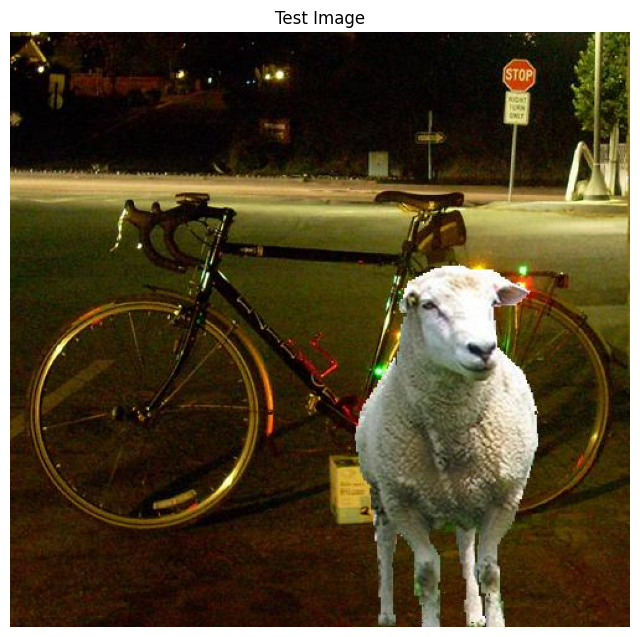

In [5]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def fuse_captions(base_caption, occlusion_summary):


    if not occlusion_summary.strip():
        return base_caption


    loc_phrase = ""
    if " in " in base_caption:
        loc_phrase = base_caption.split(" in ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " in " + loc_phrase
    if " on " in base_caption:
        loc_phrase = base_caption.split(" on ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " on " + loc_phrase


    final_text = occlusion_summary.strip()
    if final_text.endswith("."):
        final_text = final_text[:-1]


    final_caption = final_text + loc_phrase + "."
    return final_caption


test_image_path = "/content/drive/MyDrive/FYP/final_dataset/OccludedPASCAL3D_all/images/FGL1_BGL1/bicycleFGL1_BGL1_n02834778_537.JPEG"
test_image = Image.open(test_image_path).convert("RGB")


inputs = processor(images=test_image, text="", return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
generated_ids = caption_model.generate(**inputs)
base_caption = processor.decode(generated_ids[0], skip_special_tokens=True)
print("Base Generated Caption:")
print(base_caption)


test_image_cv = cv2.cvtColor(np.array(test_image), cv2.COLOR_RGB2BGR)
occlusion_summary = get_occlusion_summary(test_image_cv)
print("Occlusion Summary:")
print(occlusion_summary)


final_caption = fuse_captions(base_caption, occlusion_summary)
print("\nFinal Refined Caption:")
print(final_caption)


plt.figure(figsize=(8,8))
plt.imshow(test_image)
plt.axis("off")
plt.title("Test Image")
plt.show()


Base Generated Caption:
a baby is standing in the parking lot

0: 480x640 1 person, 1 car, 201.1ms
Speed: 9.9ms preprocess, 201.1ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 640)
Occlusion Summary:
The person partially covers the car.

Final Refined Caption:
The person partially covers the car in the parking lot.


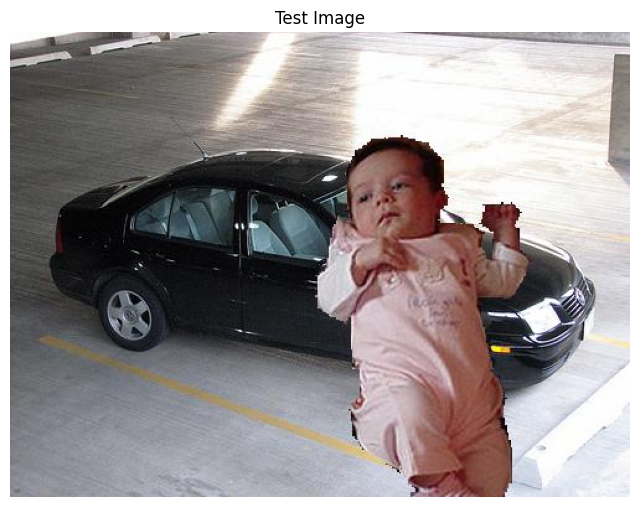

In [6]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def fuse_captions(base_caption, occlusion_summary):


    if not occlusion_summary.strip():
        return base_caption


    loc_phrase = ""
    if " in " in base_caption:
        loc_phrase = base_caption.split(" in ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " in " + loc_phrase
    if " on " in base_caption:
        loc_phrase = base_caption.split(" on ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " on " + loc_phrase


    final_text = occlusion_summary.strip()
    if final_text.endswith("."):
        final_text = final_text[:-1]


    final_caption = final_text + loc_phrase + "."
    return final_caption


test_image_path = "/content/drive/MyDrive/FYP/final_dataset/OccludedPASCAL3D_all/images/FGL1_BGL1/carFGL1_BGL1_n04166281_5317.JPEG"
test_image = Image.open(test_image_path).convert("RGB")


inputs = processor(images=test_image, text="", return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
generated_ids = caption_model.generate(**inputs)
base_caption = processor.decode(generated_ids[0], skip_special_tokens=True)
print("Base Generated Caption:")
print(base_caption)


test_image_cv = cv2.cvtColor(np.array(test_image), cv2.COLOR_RGB2BGR)
occlusion_summary = get_occlusion_summary(test_image_cv)
print("Occlusion Summary:")
print(occlusion_summary)


final_caption = fuse_captions(base_caption, occlusion_summary)
print("\nFinal Refined Caption:")
print(final_caption)


plt.figure(figsize=(8,8))
plt.imshow(test_image)
plt.axis("off")
plt.title("Test Image")
plt.show()


Base Generated Caption:
a man in a blue shirt

0: 384x640 1 person, 1 airplane, 159.5ms
Speed: 2.2ms preprocess, 159.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
Occlusion Summary:
The person partially covers the airplane.

Final Refined Caption:
The person partially covers the airplane in the blue shirt.


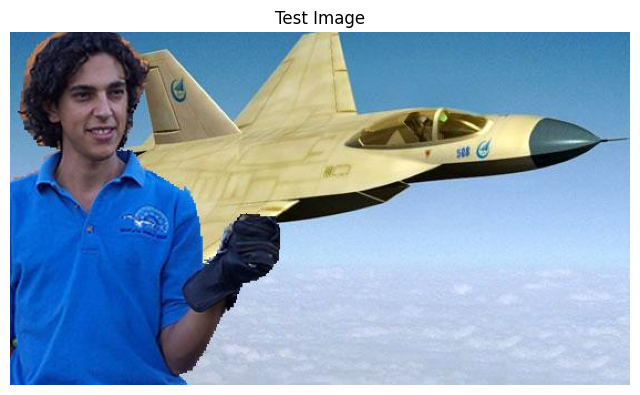

In [7]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def fuse_captions(base_caption, occlusion_summary):


    if not occlusion_summary.strip():
        return base_caption


    loc_phrase = ""
    if " in " in base_caption:
        loc_phrase = base_caption.split(" in ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " in " + loc_phrase
    if " on " in base_caption:
        loc_phrase = base_caption.split(" on ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " on " + loc_phrase


    final_text = occlusion_summary.strip()
    if final_text.endswith("."):
        final_text = final_text[:-1]


    final_caption = final_text + loc_phrase + "."
    return final_caption


test_image_path = "/content/drive/MyDrive/FYP/final_dataset/OccludedPASCAL3D_all/images/FGL1_BGL2/aeroplaneFGL1_BGL2_n03335030_1775.JPEG"
test_image = Image.open(test_image_path).convert("RGB")


inputs = processor(images=test_image, text="", return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
generated_ids = caption_model.generate(**inputs)
base_caption = processor.decode(generated_ids[0], skip_special_tokens=True)
print("Base Generated Caption:")
print(base_caption)


test_image_cv = cv2.cvtColor(np.array(test_image), cv2.COLOR_RGB2BGR)
occlusion_summary = get_occlusion_summary(test_image_cv)
print("Occlusion Summary:")
print(occlusion_summary)


final_caption = fuse_captions(base_caption, occlusion_summary)
print("\nFinal Refined Caption:")
print(final_caption)


plt.figure(figsize=(8,8))
plt.imshow(test_image)
plt.axis("off")
plt.title("Test Image")
plt.show()


Base Generated Caption:
a man in a costume and hat walking on a race track

0: 448x640 1 person, 3 cars, 1 horse, 1 umbrella, 115.1ms
Speed: 4.4ms preprocess, 115.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)
Occlusion Summary:
a man partially covering the car

Final Refined Caption:
a man partially covering the car on a race track


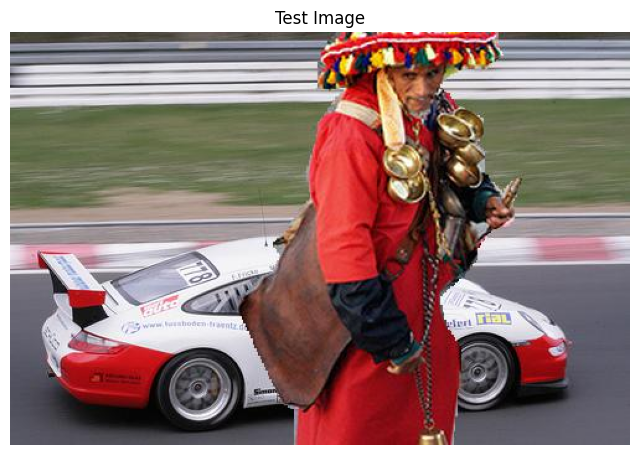

In [10]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def fuse_captions(base_caption, occlusion_summary):


    if not occlusion_summary.strip():
        return base_caption


    loc_phrase = ""
    if " in " in base_caption:
        loc_phrase = base_caption.split(" in ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " in " + loc_phrase
    if " on " in base_caption:
        loc_phrase = base_caption.split(" on ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " on " + loc_phrase


    final_text = occlusion_summary.strip()
    if final_text.endswith("."):
        final_text = final_text[:-1]


    final_caption = final_text + loc_phrase + "."
    return final_caption




test_image_path = "/content/drive/MyDrive/FYP/final_dataset/OccludedPASCAL3D_all/images/FGL1_BGL2/carFGL1_BGL2_n02958343_3041.JPEG"
test_image = Image.open(test_image_path).convert("RGB")


inputs = processor(images=test_image, text="", return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
generated_ids = caption_model.generate(**inputs)
base_caption = processor.decode(generated_ids[0], skip_special_tokens=True)
print("Base Generated Caption:")
print(base_caption)




test_image_cv = cv2.cvtColor(np.array(test_image), cv2.COLOR_RGB2BGR)
occlusion_summary = get_occlusion_summary(test_image_cv)
print("Occlusion Summary:")
print(occlusion_summay)


final_caption = fuse_captions(base_caption, occlusion_summary)
print("\nFinal Refined Caption:")
print(final_caption)

plt.figure(figsize=(8,8))
plt.imshow(test_image)
plt.axis("off")
plt.title("Test Image")
plt.show()


Base Generated Caption:
a man with a bottle of beer on his head

0: 640x320 1 person, 1 bottle, 103.7ms
Speed: 1.7ms preprocess, 103.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)
Occlusion Summary:
The person partially covers the bottle.

Final Refined Caption:
The person partially covers the bottle with his head.


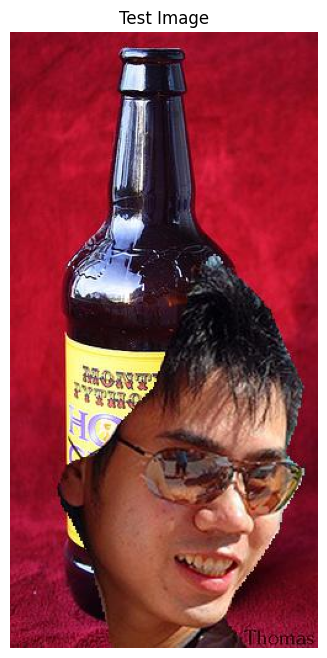

In [12]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def fuse_captions(base_caption, occlusion_summary):


    if not occlusion_summary.strip():
        return base_caption


    loc_phrase = ""
    if " in " in base_caption:
        loc_phrase = base_caption.split(" in ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " in " + loc_phrase
    if " on " in base_caption:
        loc_phrase = base_caption.split(" on ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " on " + loc_phrase


    final_text = occlusion_summary.strip()
    if final_text.endswith("."):
        final_text = final_text[:-1]


    final_caption = final_text + " with his head" + "."
    return final_caption


test_image_path = "/content/drive/MyDrive/FYP/final_dataset/OccludedPASCAL3D_all/images/FGL2_BGL1/bottleFGL2_BGL1_n02823428_388.JPEG"
test_image = Image.open(test_image_path).convert("RGB")


inputs = processor(images=test_image, text="", return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
generated_ids = caption_model.generate(**inputs)
base_caption = processor.decode(generated_ids[0], skip_special_tokens=True)
print("Base Generated Caption:")
print(base_caption)


test_image_cv = cv2.cvtColor(np.array(test_image), cv2.COLOR_RGB2BGR)
occlusion_summary = get_occlusion_summary(test_image_cv)
print("Occlusion Summary:")
print(occlusion_summary)


final_caption = fuse_captions(base_caption, occlusion_summary)
print("\nFinal Refined Caption:")
print(final_caption)


plt.figure(figsize=(8,8))
plt.imshow(test_image)
plt.axis("off")
plt.title("Test Image")
plt.show()


Base Generated Caption:
a dog is standing in front of a television

0: 480x640 1 cat, 1 dog, 144.4ms
Speed: 2.5ms preprocess, 144.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)
Occlusion Summary:
The dog partially covers the cat.

Final Refined Caption:
The dog partially covers the cat in front of a television.


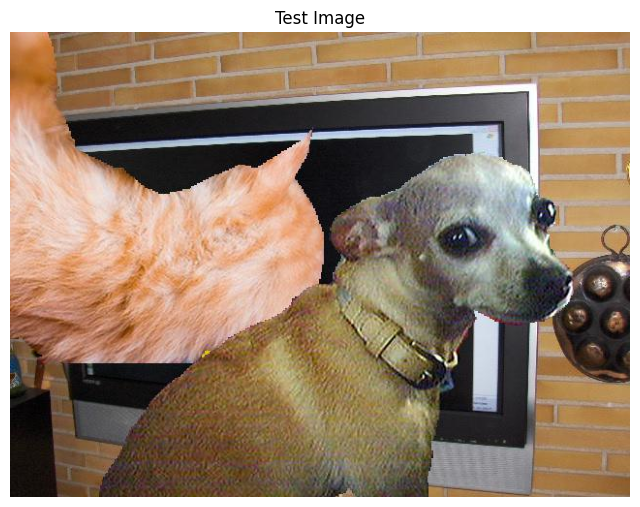

In [13]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def fuse_captions(base_caption, occlusion_summary):


    if not occlusion_summary.strip():
        return base_caption


    loc_phrase = ""
    if " in " in base_caption:
        loc_phrase = base_caption.split(" in ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " in " + loc_phrase
    if " on " in base_caption:
        loc_phrase = base_caption.split(" on ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " on " + loc_phrase

    final_text = occlusion_summary.strip()
    if final_text.endswith("."):
        final_text = final_text[:-1]


    final_caption = final_text + loc_phrase + "."
    return final_caption


test_image_path = "/content/drive/MyDrive/FYP/final_dataset/OccludedPASCAL3D_all/images/FGL3_BGL1/tvmonitorFGL3_BGL1_n06278475_828.JPEG"
test_image = Image.open(test_image_path).convert("RGB")


inputs = processor(images=test_image, text="", return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
generated_ids = caption_model.generate(**inputs)
base_caption = processor.decode(generated_ids[0], skip_special_tokens=True)
print("Base Generated Caption:")
print(base_caption)


test_image_cv = cv2.cvtColor(np.array(test_image), cv2.COLOR_RGB2BGR)
occlusion_summary = get_occlusion_summary(test_image_cv)
print("Occlusion Summary:")
print(occlusion_summary)


final_caption = fuse_captions(base_caption, occlusion_summary)
print("\nFinal Refined Caption:")
print(final_caption)


plt.figure(figsize=(8,8))
plt.imshow(test_image)
plt.axis("off")
plt.title("Test Image")
plt.show()


Base Generated Caption:
a horse with long hair standing on a wooden floor

0: 480x640 1 person, 1 horse, 1 couch, 116.8ms
Speed: 3.5ms preprocess, 116.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)
Occlusion Summary:
The horse partially covers the couch.

Final Refined Caption:
The horse partially covers the couch on the wooden floor.


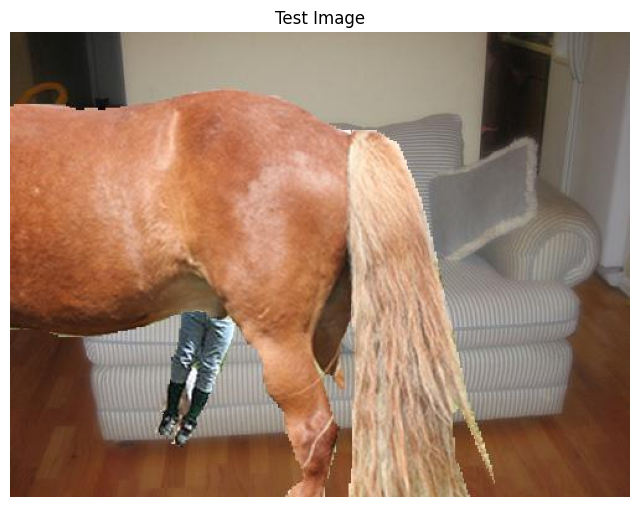

In [15]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def fuse_captions(base_caption, occlusion_summary):


    if not occlusion_summary.strip():
        return base_caption


    loc_phrase = ""
    if " in " in base_caption:
        loc_phrase = base_caption.split(" in ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " in " + loc_phrase
    if " on " in base_caption:
        loc_phrase = base_caption.split(" on ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " on " + loc_phrase


    final_text = occlusion_summary.strip()
    if final_text.endswith("."):
        final_text = final_text[:-1]


    final_caption = final_text + loc_phrase + "."
    return final_caption


test_image_path = "/content/drive/MyDrive/FYP/final_dataset/OccludedPASCAL3D_all/images/FGL3_BGL2/sofaFGL3_BGL2_n03693474_13654.JPEG"
test_image = Image.open(test_image_path).convert("RGB")


inputs = processor(images=test_image, text="", return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
generated_ids = caption_model.generate(**inputs)
base_caption = processor.decode(generated_ids[0], skip_special_tokens=True)
print("Base Generated Caption:")
print(base_caption)


test_image_cv = cv2.cvtColor(np.array(test_image), cv2.COLOR_RGB2BGR)
occlusion_summary = get_occlusion_summary(test_image_cv)
print("Occlusion Summary:")
print(occlusion_summary)


final_caption = fuse_captions(base_caption, occlusion_summary)
print("\nFinal Refined Caption:")
print(final_caption)

plt.figure(figsize=(8,8))
plt.imshow(test_image)
plt.axis("off")
plt.title("Test Image")
plt.show()


Base Generated Caption:
a white dog sitting on a dock next to a sailboat

0: 448x640 1 dog, 131.8ms
Speed: 2.2ms preprocess, 131.8ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)
Occlusion Summary:
a dog partially covering a boat

Final Refined Caption:
a white dog partially covering a sailboat


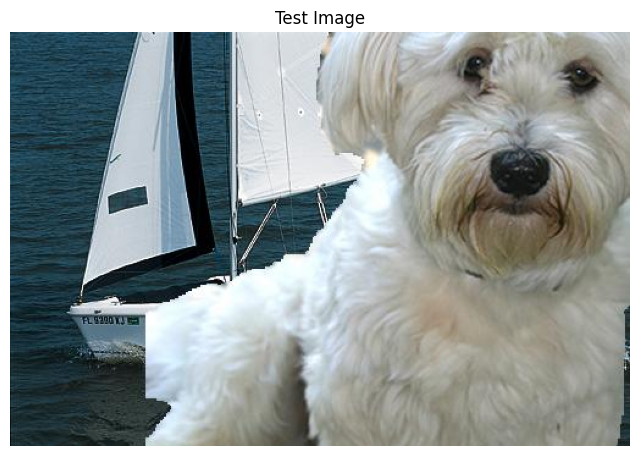

In [18]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def fuse_captions(base_caption, occlusion_summary):


    if not occlusion_summary.strip():
        return base_caption


    loc_phrase = ""
    if " in " in base_caption:
        loc_phrase = base_caption.split(" in ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " in " + loc_phrase
    if " on " in base_caption:
        loc_phrase = base_caption.split(" on ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " on " + loc_phrase


    final_text = occlusion_summary.strip()
    if final_text.endswith("."):
        final_text = final_text[:-1]


    final_caption = final_text + loc_phrase + "."
    return final_caption



test_image_path = "/content/drive/MyDrive/FYP/final_dataset/OccludedPASCAL3D_all/images/FGL3_BGL3/boatFGL3_BGL3_n04128499_5841.JPEG"
test_image = Image.open(test_image_path).convert("RGB")


inputs = processor(images=test_image, text="", return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
generated_ids = caption_model.generate(**inputs)
base_caption = processor.decode(generated_ids[0], skip_special_tokens=True)
print("Base Generated Caption:")
print(base_caption)




test_image_cv = cv2.cvtColor(np.array(test_image), cv2.COLOR_RGB2BGR)
occlusion_summary = get_occlusion_summary(test_image_cv)
print("Occlusion Summary:")
print(occlusion_summary)


final_caption = fuse_captions(base_caption, occlusion_summary)
print("\nFinal Refined Caption:")
print(final_caption)


plt.figure(figsize=(8,8))
plt.imshow(test_image)
plt.axis("off")
plt.title("Test Image")
plt.show()


Base Generated Caption:
a big cat is sitting on a bench next to a white car

0: 416x640 2 cars, 1 dog, 1 cow, 117.2ms
Speed: 1.8ms preprocess, 117.2ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)
Occlusion Summary:
a cat partially covers the car

Final Refined Caption:
a big cat partially covers a white car


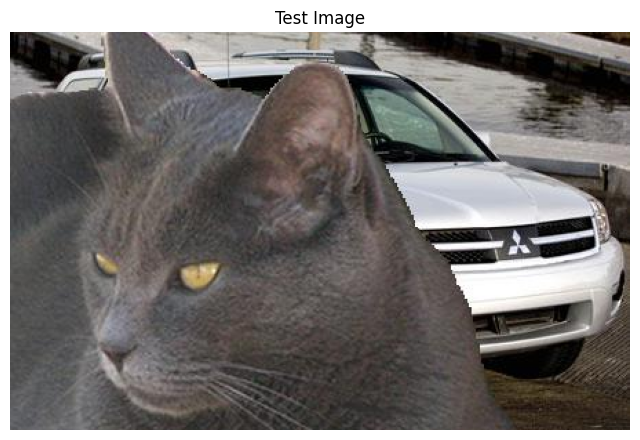

In [21]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def fuse_captions(base_caption, occlusion_summary):


    if not occlusion_summary.strip():
        return base_caption


    loc_phrase = ""
    if " in " in base_caption:
        loc_phrase = base_caption.split(" in ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " in " + loc_phrase
    if " on " in base_caption:
        loc_phrase = base_caption.split(" on ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " on " + loc_phrase


    final_text = occlusion_summary.strip()
    if final_text.endswith("."):
        final_text = final_text[:-1]


    final_caption = final_text + loc_phrase + "."
    return final_caption



test_image_path = "/content/drive/MyDrive/FYP/final_dataset/OccludedPASCAL3D_all/images/FGL3_BGL3/carFGL3_BGL3_n04285965_20301.JPEG"
test_image = Image.open(test_image_path).convert("RGB")



inputs = processor(images=test_image, text="", return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
generated_ids = caption_model.generate(**inputs)
base_caption = processor.decode(generated_ids[0], skip_special_tokens=True)
print("Base Generated Caption:")
print(base_caption)


test_image_cv = cv2.cvtColor(np.array(test_image), cv2.COLOR_RGB2BGR)
occlusion_summary = get_occlusion_summary(test_image_cv)
print("Occlusion Summary:")
print(occlusion_summary)


final_caption = fuse_captions(base_caption, occlusion_summary)
print("\nFinal Refined Caption:")
print(final_caption)


plt.figure(figsize=(8,8))
plt.imshow(test_image)
plt.axis("off")
plt.title("Test Image")
plt.show()


Base Generated Caption:
a dog is standing on a boat in the water

0: 448x640 4 boats, 1 dog, 160.7ms
Speed: 2.8ms preprocess, 160.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)
Occlusion Summary:
The dog partially covers the boat.

Final Refined Caption:
The dog partially covers the boat in the water.


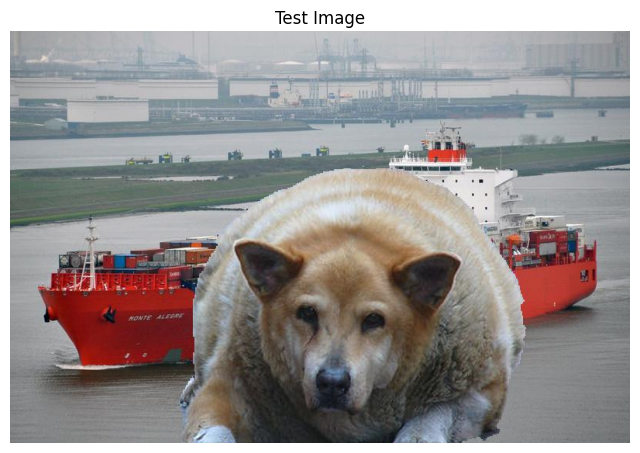

In [22]:
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def fuse_captions(base_caption, occlusion_summary):


    if not occlusion_summary.strip():
        return base_caption


    loc_phrase = ""
    if " in " in base_caption:
        loc_phrase = base_caption.split(" in ", 1)[1].strip()

        if loc_phrase.startswith("a "):
            loc_phrase = "the " + loc_phrase[2:]
        elif loc_phrase.startswith("an "):
            loc_phrase = "the " + loc_phrase[3:]
        loc_phrase = " in " + loc_phrase



    final_text = occlusion_summary.strip()
    if final_text.endswith("."):
        final_text = final_text[:-1]

    final_caption = final_text + loc_phrase + "."
    return final_caption


test_image_path = "/content/drive/MyDrive/FYP/final_dataset/OccludedPASCAL3D_all/images/FGL2_BGL2/boatFGL2_BGL2_n04196502_17048.JPEG"
test_image = Image.open(test_image_path).convert("RGB")


inputs = processor(images=test_image, text="", return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
generated_ids = caption_model.generate(**inputs)
base_caption = processor.decode(generated_ids[0], skip_special_tokens=True)
print("Base Generated Caption:")
print(base_caption)


test_image_cv = cv2.cvtColor(np.array(test_image), cv2.COLOR_RGB2BGR)
occlusion_summary = get_occlusion_summary(test_image_cv)
print("Occlusion Summary:")
print(occlusion_summary)


final_caption = fuse_captions(base_caption, occlusion_summary)
print("\nFinal Refined Caption:")
print(final_caption)


plt.figure(figsize=(8,8))
plt.imshow(test_image)
plt.axis("off")
plt.title("Test Image")
plt.show()
